In [87]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import kWaveGrid
from models.pact import Wavefront_SOS
from utils.dataio import *
from utils.simulations import get_water_SOS
from utils.visualization import *
from utils.reconstruction import get_coordinates
from utils.utils_torch import crop_half, get_fourier_coord

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/numerical/'

### Load Images

In [88]:
v_das = 1510

In [89]:
IP_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
IP_das = load_mat(os.path.join(RESULTS_DIR, 'DAS', 'v_das={:.1f}m·s⁻¹'.format(v_das), 'IP_rec.mat'))
IP_dual_das = load_mat(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'IP_rec.mat'))
IP_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'IP_rec.mat'))
IP_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'IP_rec.mat'))

SOS_gt = load_mat(os.path.join(DATA_DIR, 'SOS_easy.mat'))
SOS_uniform = load_mat(os.path.join(DATA_DIR, 'SOS_uniform.mat'))
SOS_dual = load_mat(os.path.join(DATA_DIR, 'SOS_SB.mat'))
SOS_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'SOS_rec.mat'))
SOS_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'SOS_rec.mat'))

t_das = load_log(os.path.join(RESULTS_DIR, 'DAS', 'v_das={:.1f}m·s⁻¹'.format(v_das), 'log.json'))['time']
t_dual_das = load_log(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'log.json'))['time']
t_apact = load_log(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'log.json'))['time']
t_nf_apact = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'log.json'))['time']

In [90]:
[IP_gt, IP_das, IP_dual_das, IP_apact, IP_nf_apact] = \
    [standardize(img) for img in [IP_gt, IP_das, IP_dual_das, IP_apact, IP_nf_apact]]
data_range_img = IP_das.max() - IP_das.min()
data_range_SOS = SOS_gt.max() - SOS_gt.min()

### Calculate Wavefronts

In [91]:
config = load_config(os.path.join('../', 'config.yaml'))
bps, tps = config['basic_params'], config['numerical']
R_ring = bps['R_ring'] # Radius to ring [m].
R_body = tps['R_body'] # Radius to center [m].
l_patch = bps['l_patch'] # Patch size [m].
kgrid = kWaveGrid([tps['Nx'], tps['Ny']], [bps['dx'], bps['dy']])
v0 = get_water_SOS(tps['T'])

In [92]:
wavefront_SOS = Wavefront_SOS(R_body, v0, kgrid.x_vec, kgrid.y_vec, n_thetas=360)
wavefront_SOS.cuda()
wavefront_SOS.eval()

Wavefront_SOS()

Pick a patch.

In [93]:
i, j = 18, 15
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, l_patch)
x, y = (j-12)*l_patch / 4, (12-i)*l_patch / 4
k2D, theta2D = get_fourier_coord(N=80, l=l_patch, device='cpu')
print(r*1e3, phi)

5.366563145999496 2.677945044588987


Calculate ground truth and NF-APACT wavefronts.

In [94]:
thetas, wf_gt = wavefront_SOS(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_gt).cuda())
wf_gt = wf_gt.detach().cpu().numpy()
thetas, wf_dual = wavefront_SOS(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_dual).cuda())
wf_dual = wf_dual.detach().cpu().numpy()
thetas, wf_nf_apact = wavefront_SOS(torch.tensor(x).cuda(), torch.tensor(y).cuda(), torch.tensor(SOS_nf_apact).cuda())
wf_nf_apact = wf_nf_apact.detach().cpu().numpy()
thetas = thetas.detach().cpu().numpy()
wf_das = np.ones_like(wf_gt) * R_ring * (1-v0/v_das)

Calculate APACT wavefront.

In [95]:
wf_params = torch.load(os.path.join(RESULTS_DIR, 'APACT', '32delays', 'wf_params.pth')).detach().cpu().numpy()
dc ,x2, y2 = wf_params[i*25+j]
wf_apact = dc + x2*np.cos(2*thetas) + y2*np.sin(2*thetas)

### Create Figure

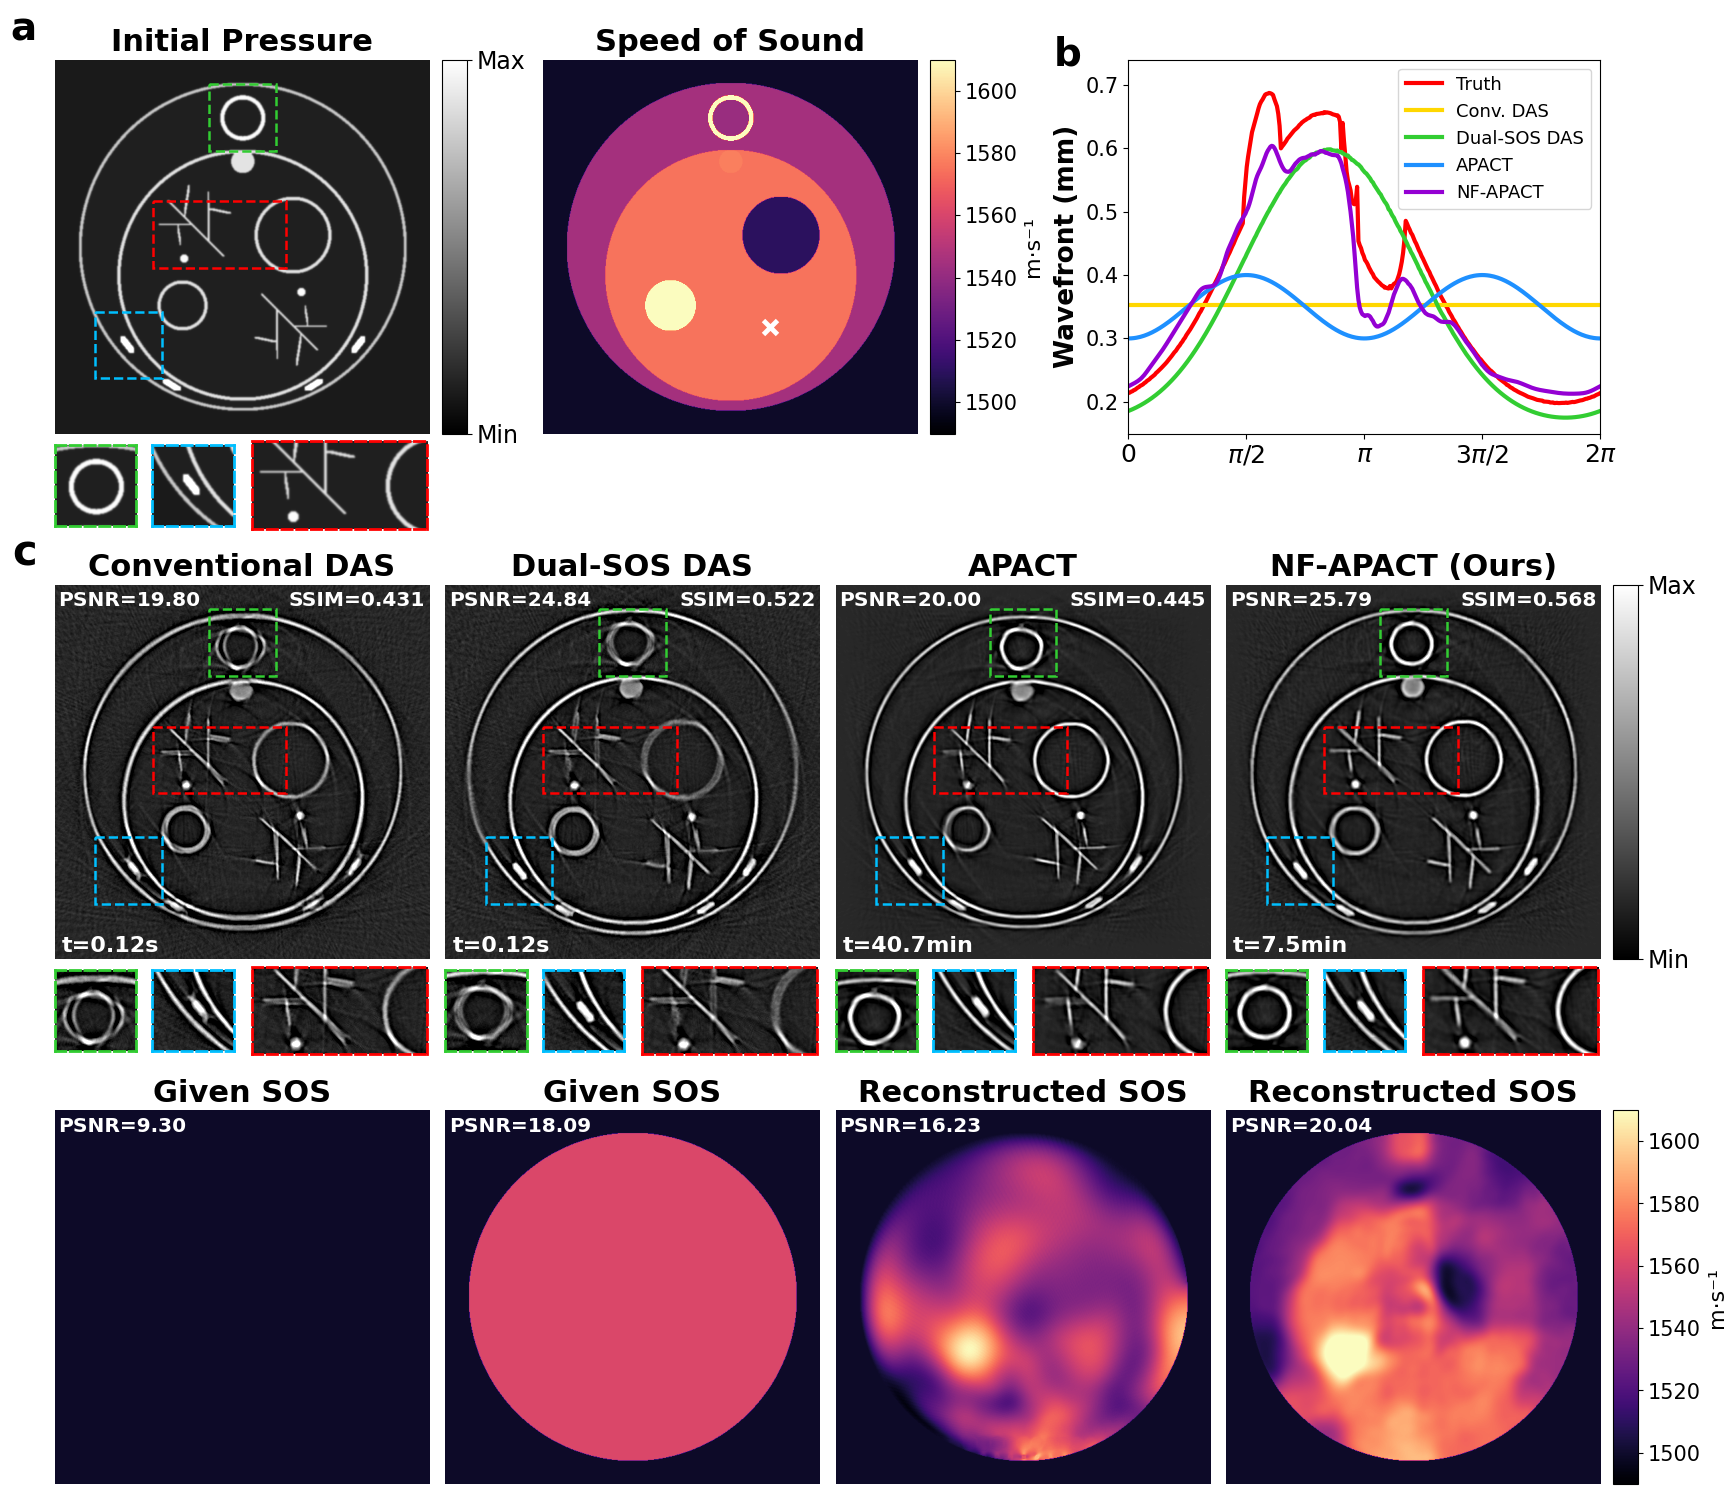

In [96]:
patches = [(36, 230, 100, 100, 'limegreen'), (377, 60, 100, 100, 'deepskyblue'), (212, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(21.2, 18.5))
gs = GridSpec(30, 17)
norm = Normalize(vmax=5, vmin=-1)
norm_SOS = Normalize(vmax=1610, vmin=1490)

# Panel a: Numerical phantom.
ax = plt.subplot(gs[0:8,0:4])
plt.title('a', loc='left', x=-0.12, y=1.03, fontsize=28, fontweight='semibold', color='black')
plt.title('Initial Pressure', fontsize=22, fontweight='semibold')
plt.axis('off')
plt.imshow(IP_gt, cmap='gray', norm=norm)
cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.set_ticks([5, -1])
cb.set_ticklabels(['Max', 'Min'], fontsize=17)
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[8:10,k:k+1+(k==2)])
        plt.imshow(IP_gt[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

ax = plt.subplot(gs[0:8,5:9])
plt.axis('off')
plt.title('Speed of Sound', fontsize=22, fontweight='semibold')
plt.imshow(SOS_gt, cmap='magma', norm=norm_SOS)
plt.plot(idy, idx, marker='x', mew=3.5, color='white', markersize=10)
cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_SOS)
cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=15)
cb.set_label('m·s⁻¹', fontsize=16)

# Panel b: comaping Wavefronts.
plt.subplot(gs[0:8,11:16])
plt.plot(thetas, wf_gt*1e3, label='Truth', color='red', linewidth=3.)
plt.plot(thetas, wf_das*1e3, label='Conv. DAS', color='gold', linewidth=3.)
plt.plot(thetas, wf_dual*1e3, label='Dual-SOS DAS', color='limegreen', linewidth=3.)
plt.plot(thetas, wf_apact*1e3, label='APACT', color='dodgerblue', linewidth=3.)
plt.plot(thetas, wf_nf_apact*1e3, label='NF-APACT', color='darkviolet', linewidth=3.)
plt.legend(fontsize=13)
plt.xlim([0, 2*np.pi])
plt.ylim([0.15, 0.74])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=18)
plt.yticks(fontsize=15)
plt.ylabel('Wavefront (mm)', fontsize=19, fontweight='bold')
plt.text(s='b', x=-1, y=0.73, fontsize=28, fontweight='semibold', color='black')

# Panel c: Reconstruction results.
for idx, (img, method, time, SOS, SOS_title) in enumerate(zip([IP_das, IP_dual_das, IP_apact, IP_nf_apact],
                                                              ['Conventional DAS', 'Dual-SOS DAS', 'APACT', 'NF-APACT (Ours)'],
                                                              ['t={:.2f}s'.format(t_das), 't={:.2f}s'.format(t_dual_das), 't={:.1f}min'.format(t_apact/60), 't={:.1f}min'.format(t_nf_apact/60)],
                                                              [SOS_uniform, SOS_dual, SOS_apact, SOS_nf_apact],
                                                              ['Given SOS', 'Given SOS', 'Reconstructed SOS', 'Reconstructed SOS'])):
    ax = plt.subplot(gs[11:19,idx*4:(idx+1)*4])
    plt.title(method, fontsize=22, fontweight='semibold')
    plt.axis('off')
    plt.imshow(img, cmap='gray', norm=norm)
    plt.text(s=time, x=10, y=550, fontweight='semibold', fontsize=16, color='white')
    plt.title('PSNR={:.2f}'.format(psnr(IP_gt, img, data_range=data_range_img)), loc='left', x=0.01, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    plt.title('SSIM={:.3f}'.format(ssim(IP_gt, img, data_range=data_range_img)), loc='right', x=0.99, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    if idx == 0:
        plt.text(s='c', x=-65, y=-30, fontsize=30, fontweight='semibold', color='black')
    elif idx == 3:
        cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=17)
    
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[19:21,idx*4+k:idx*4+k+1+(k==2)])
        plt.imshow(img[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

    ax = plt.subplot(gs[22:30,idx*4:(idx+1)*4])
    plt.axis('off')
    plt.title(SOS_title, fontsize=22, fontweight='semibold')
    plt.imshow(SOS, cmap='magma', norm=norm_SOS)
    if idx >= 0:
        plt.title('PSNR={:.2f}'.format(psnr(SOS, SOS_gt, data_range=data_range_SOS)), loc='left', x=0.01, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
        # plt.title('SSIM={:.3f}'.format(ssim(SOS, SOS_gt, data_range=data_range_SOS)), loc='right', x=0.99, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    if idx == 3:
        cax = fig.add_axes([ax.get_position().x1+.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=15)
        cb.set_label('m·s⁻¹', fontsize=16)
    
plt.savefig('figure_simulation.png', bbox_inches='tight', dpi=256)